<a href="https://colab.research.google.com/github/candiceevemiller/personal-projects/blob/main/AAPL_Stock_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# AAPL.csv
url = 'https://raw.githubusercontent.com/candiceevemiller/personal-projects/main/AAPL.csv'

In [ ]:
import pandas as pd
import csv
import urllib.request
from datetime import datetime

data = pd.read_csv(url)

for i in range(len(data['Date'])):
  data['Date'][i] = datetime.fromisoformat(data['Date'][i])

print(data)

time_step = np.array(data['Date'])
closing_price = np.array(data['Close'])

print(time_step)
print(closing_price)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


                      Date        Open  ...   Adj Close     Volume
0      1980-12-12 00:00:00    0.128348  ...    0.100453  469033600
1      1980-12-15 00:00:00    0.122210  ...    0.095213  175884800
2      1980-12-16 00:00:00    0.113281  ...    0.088224  105728000
3      1980-12-17 00:00:00    0.115513  ...    0.090408   86441600
4      1980-12-18 00:00:00    0.118862  ...    0.093029   73449600
...                    ...         ...  ...         ...        ...
10352  2022-01-03 00:00:00  177.830002  ...  182.009995  104487900
10353  2022-01-04 00:00:00  182.630005  ...  179.699997   99310400
10354  2022-01-05 00:00:00  179.610001  ...  174.919998   94537600
10355  2022-01-06 00:00:00  172.699997  ...  172.000000   96904000
10356  2022-01-07 00:00:00  172.889999  ...  172.169998   86580100

[10357 rows x 7 columns]
[datetime.datetime(1980, 12, 12, 0, 0)
 datetime.datetime(1980, 12, 15, 0, 0)
 datetime.datetime(1980, 12, 16, 0, 0) ...
 datetime.datetime(2022, 1, 5, 0, 0) datetime.dat

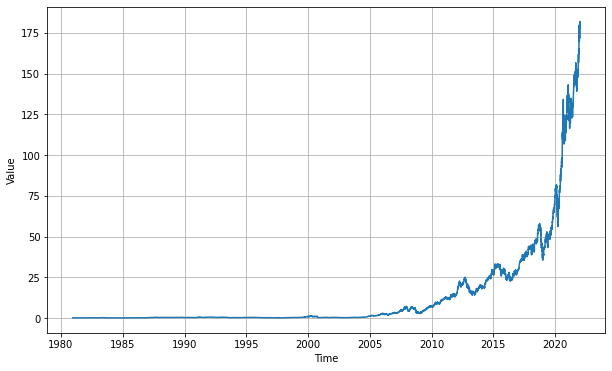

In [ ]:
time = time_step
series = closing_price
plt.figure(figsize=(10, 6))
plot_series(time_step, closing_price)

In [ ]:
split_time = len(data)-365
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = split_time


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 90
batch_size = 64
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding='causal',
                      activation='relu',
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='relu')
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 10))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(9000,)
Epoch 1/100
140/140 [==============================] - 7s 22ms/step - loss: 3.9290 - mae: 4.2605 - lr: 1.0000e-08
Epoch 2/100
140/140 [==============================] - 3s 21ms/step - loss: 3.9291 - mae: 4.2605 - lr: 1.2589e-08
Epoch 3/100
140/140 [==============================] - 3s 21ms/step - loss: 3.9290 - mae: 4.2604 - lr: 1.5849e-08
Epoch 4/100
140/140 [==============================] - 3s 21ms/step - loss: 3.9290 - mae: 4.2604 - lr: 1.9953e-08
Epoch 5/100
140/140 [==============================] - 3s 21ms/step - loss: 3.9290 - mae: 4.2604 - lr: 2.5119e-08
Epoch 6/100
140/140 [==============================] - 3s 21ms/step - loss: 3.9290 - mae: 4.2604 - lr: 3.1623e-08
Epoch 7/100
140/140 [==============================] - 3s 21ms/step - loss: 3.9290 - mae: 4.2604 - lr: 3.9811e-08
Epoch 8/100
140/140 [==============================] - 3s 21ms/step - loss: 3.9290 - mae: 4.2603 - l

(1e-08, 10.0, 0.0, 5.0)

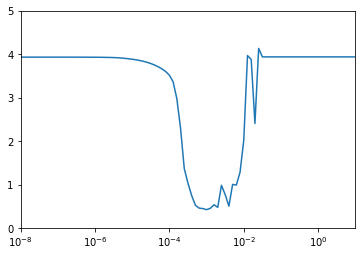

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 10, 0, 5])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=365, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=30,
                      strides=1, padding='causal',
                      activation='relu',
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation='relu')
])



optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
135/135 [==============================] - 13s 52ms/step - loss: 3.6380 - mae: 3.9661
Epoch 2/100
135/135 [==============================] - 9s 53ms/step - loss: 3.1714 - mae: 3.4748
Epoch 3/100
135/135 [==============================] - 10s 53ms/step - loss: 1.5102 - mae: 1.7586
Epoch 4/100
135/135 [==============================] - 10s 53ms/step - loss: 0.7883 - mae: 0.9981
Epoch 5/100
135/135 [==============================] - 10s 54ms/step - loss: 0.7574 - mae: 0.9569
Epoch 6/100
135/135 [==============================] - 10s 54ms/step - loss: 0.7150 - mae: 0.9092
Epoch 7/100
135/135 [==============================] - 10s 54ms/step - loss: 0.7158 - mae: 0.9099
Epoch 8/100
135/135 [==============================] - 10s 54ms/step - loss: 0.6519 - mae: 0.8423
Epoch 9/100
135/135 [==============================] - 10s 54ms/step - loss: 0.6376 - mae: 0.8281
Epoch 10/100
135/135 [==============================] - 10s 54ms/step - loss: 0.5919 - mae: 0.7787
Epoch 11/100
135/135

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

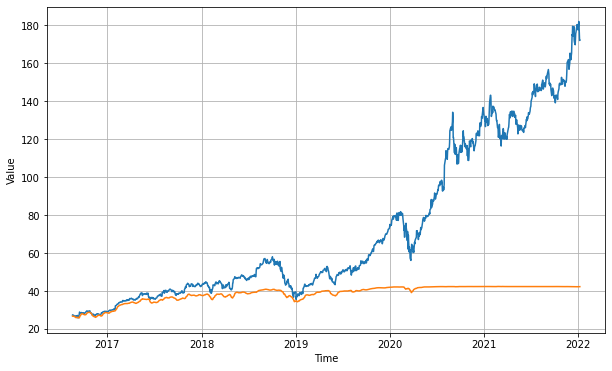

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

33.292637

<Figure size 432x288 with 0 Axes>

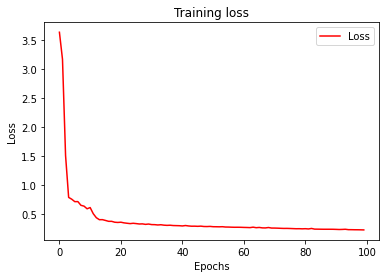

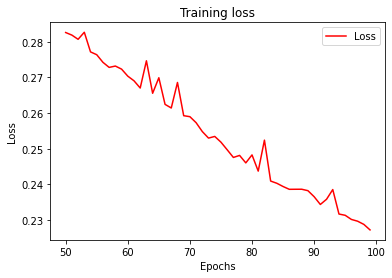

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[50:]
zoomed_epochs = range(50,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[26.709074 26.71666  26.696066 ... 42.265114 42.27448  42.2738  ]
